In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
from abc import ABC, abstractmethod
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
!pip install -U cvxportfolio
import cvxportfolio as cvx

In [ ]:
class DataLoader:
    """
    Loads price series for assets, benchmarks, and macro series (e.g., inflation).
    """
    def __init__(self, tickers: list, start: str = '2010-01-01', end: str = None, interval: str = '1mo'):
        self.tickers = tickers
        self.start = start
        self.end = end or datetime.today().strftime('%Y-%m-%d')
        self.interval = interval

    def fetch_prices(self) -> pd.DataFrame:
        data = yf.download(
            tickers=self.tickers,
            start=self.start,
            end=self.end,
            interval=self.interval,
            auto_adjust=True,
            progress=False
        )['Close']

        return data.ffill()

In [ ]:
class BaseStrategy(ABC):
    """Interface for all strategies."""
    @abstractmethod
    def __init__(self, tickers, name, **params):
        """Store any strategy-specific parameters."""
        self.tickers = tickers
        self.name = name

    @abstractmethod
    def optimize(
        self,
        current_portfolio: np.ndarray,
        new_capital: float,
        price_history: pd.DataFrame,
        returns_history: pd.DataFrame,
        **kwargs
    ):
        """
        Given current_weights, cash, and history, compute new allocations.
        Strategies can decide to use prices, returns, covariances, macro series, etc.
        """
        pass

In [ ]:
class RiskParityStrategy(BaseStrategy):
    def __init__(self, tickers, name=None, fractional_shares=True):
        super().__init__(tickers, name)
        self.fractional_shares = fractional_shares

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):
        current_prices = price_history.iloc[-1].values

        # Current portfolio
        A = current_portfolio
        B = new_capital
        V0 = np.sum(A)
        Vt = V0 + B

        # Risk weighting
        vol = returns_history.std()
        inv_vol = 1 / vol
        w = inv_vol / inv_vol.sum()

        target_portfolio = Vt * w
        allocation = np.maximum(0, target_portfolio - current_portfolio)
        # Normalize allocation to respect new_capital limitation
        if allocation.sum() > new_capital:
            allocation = allocation / allocation.sum() * new_capital

        new_portfolio = current_portfolio + allocation

        if self.fractional_shares:
            wnew = new_portfolio / new_portfolio.sum()

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': wnew,
            'Unused': np.minimum(0, target_portfolio - current_portfolio)
        }, index=self.tickers)

In [ ]:
class MaxSharpeStrategy(BaseStrategy):
    def __init__(self, tickers, name=None, fractional_shares=True, **params):
        super().__init__(tickers, name)
        self.fractional_shares = fractional_shares

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):
        V0 = np.sum(current_portfolio)
        Vt = V0 + new_capital

        mu = returns_history.mean().values
        cov = returns_history.cov().values
        n = len(mu)
        min_weights = current_portfolio / Vt

        def sharpe_neg(w):
            port_return = np.dot(mu, w)
            port_std = np.sqrt(np.dot(w.T, np.dot(cov, w)))
            if port_std == 0:
                return np.inf
            return -port_return / port_std

        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "ineq", "fun": lambda w: w - min_weights}
        ]

        bounds = [(0.0, 1.0)] * n
        x0 = np.full(n, 1 / n)

        result = minimize(sharpe_neg, x0, method="SLSQP", bounds=bounds, constraints=constraints)

        weights = result.x
        target_portfolio = weights * Vt
        allocation = np.maximum(target_portfolio - current_portfolio, 0)
        new_portfolio = current_portfolio + allocation

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
            'Unused': np.minimum(0, target_portfolio - current_portfolio)
        }, index=self.tickers)

In [ ]:
class MaxSortinoStrategy(BaseStrategy):
    def __init__(self, tickers, name=None, fractional_shares=True, **params):
        super().__init__(tickers, name)
        self.fractional_shares = fractional_shares

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):

        V0 = np.sum(current_portfolio)
        Vt = V0 + new_capital

        mu = returns_history.mean().values
        downside_returns = returns_history.copy()
        downside_returns[downside_returns > 0] = 0
        downside_std = downside_returns.std().values
        n = len(mu)

        min_weights = current_portfolio / Vt

        def sortino_neg(w):
            port_return = np.dot(mu, w)
            downside_risk = np.sqrt(np.dot((w * downside_std), (w * downside_std)))
            if downside_risk == 0:
                return np.inf
            return -port_return / downside_risk

        constraints = [
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "ineq", "fun": lambda w: w - min_weights}
        ]
        bounds = [(0.0, 1.0)] * n
        x0 = np.full(n, 1 / n)

        result = minimize(sortino_neg, x0, method="SLSQP", bounds=bounds, constraints=constraints)
        weights = result.x
        target_portfolio = weights * Vt
        allocation = np.maximum(target_portfolio - current_portfolio, 0)
        new_portfolio = current_portfolio + allocation

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
            'Unused': np.minimum(0, target_portfolio - current_portfolio)
        }, index=self.tickers)

In [ ]:
class MomentumStrategy(BaseStrategy):
    def __init__(self, tickers, name=None, lookback=6, diversification=False, **params):
        super().__init__(tickers, name)
        self.lookback = lookback
        self.fractional_shares = True  # assumed
        self.diversification = diversification

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):
        V0 = np.sum(current_portfolio)
        Vt = V0 + new_capital

        # Classic Momentum: total return over lookback months
        #momentum_returns = price_history.pct_change(self.lookback).iloc[-1]

        # Smooth momentum signal from spikes as mean is a low pass filter
        momentum_returns = returns_history[-self.lookback:].mean()

        # Ignore losers
        momentum_returns[momentum_returns < 0] = 0

        # Ignore high volatility assets
        vol = returns_history[-self.lookback:].std()
        momentum_returns[vol > 0.1] = 0

        equal_weights = np.full(len(self.tickers), 1 / len(self.tickers))
        if momentum_returns.sum() == 0:
            weights = equal_weights  # fallback: equal weight
        else:
            weights = (momentum_returns / momentum_returns.sum()).values

        if self.diversification:
            weights = 0.7 * weights + 0.3 * equal_weights

        target_portfolio = weights * Vt
        allocation = np.maximum(target_portfolio - current_portfolio, 0)

        # Normalize allocation to respect new_capital limitation
        if allocation.sum() > new_capital:
            allocation = allocation / allocation.sum() * new_capital

        new_portfolio = current_portfolio + allocation

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
            'Unused': np.minimum(0, target_portfolio - current_portfolio)
        }, index=self.tickers)

In [ ]:
class ValueAveragingStrategy(BaseStrategy):
    def __init__(self, tickers, name=None, target_growth_rate=0.02, **params):
        super().__init__(tickers, name)
        self.target_growth_rate = target_growth_rate
        self.t = 0

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):

        V0 = np.sum(current_portfolio)
        Vtarget = new_capital * (self.t + 1) * (1 + self.target_growth_rate)
        self.t += 1
        D = max(0, Vtarget - V0)
        D = min(D, new_capital)

        n_assets = len(self.tickers)
        equal_alloc = D / n_assets if D > 0 else 0
        target_portfolio = current_portfolio + equal_alloc

        allocation = np.maximum(target_portfolio - current_portfolio, 0)

        # Normalize allocation to respect new_capital limitation
        if allocation.sum() > new_capital:
            allocation = allocation / allocation.sum() * new_capital

        new_portfolio = current_portfolio + allocation

        weights = new_portfolio / (V0 + D) if (V0 + D) > 0 else np.zeros_like(new_portfolio)

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
            'Unused': np.minimum(0, target_portfolio - current_portfolio)
        }, index=self.tickers)


In [ ]:
class MinVarianceStrategy(BaseStrategy):
    def __init__(self, tickers, name=None):
        super().__init__(tickers, name)

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):
        cov = returns_history.cov().values
        cov = 0.5 * (cov + cov.T)
        n = len(cov)
        Vt = np.sum(current_portfolio) + new_capital

        w = cp.Variable(n)
        objective = cp.Minimize(cp.quad_form(w, cov))
        constraints = [
            cp.sum(w) == 1,
            w >= current_portfolio / Vt
        ]
        cp.Problem(objective, constraints).solve()

        weights = w.value
        allocation = (weights * Vt - current_portfolio).round(0)
        new_portfolio = current_portfolio + allocation

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
        }, index=self.tickers)

In [ ]:
class BlackLittermanMVO(BaseStrategy):
    def __init__(self, tickers, name=None, implied_weights=None, tau=0.05, risk_aversion=1.0):
        super().__init__(tickers, name)
        if len(implied_weights) != len(tickers):
            raise ValueError("Number of implied weights must match the number of tickers.")
        self.implied_weights = np.array(implied_weights) if implied_weights else np.full(len(tickers), 1 / len(tickers))
        self.tau = tau
        self.risk_aversion = risk_aversion

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):
        # Mean is not used
        #mu = returns_history.mean().values

        cov = returns_history.cov().values
        cov = 0.5 * (cov + cov.T)

        V0 = np.sum(current_portfolio)
        Vt = V0 + new_capital

        pi = self.risk_aversion * cov @ self.implied_weights
        mu_bl = pi  # Simplified BL adjustment

        n = len(mu_bl)
        w = cp.Variable(n)

        expected_return = mu_bl @ w
        risk = cp.quad_form(w, cov)
        objective = cp.Maximize(expected_return - self.risk_aversion * risk)
        constraints = [
            cp.sum(w) == 1,
            w >= current_portfolio / Vt
        ]
        cp.Problem(objective, constraints).solve()

        weights = w.value
        allocation = (weights * Vt - current_portfolio).round(0)
        new_portfolio = current_portfolio + allocation

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
        }, index=self.tickers)

In [ ]:
class CVaRStrategy(BaseStrategy):
    def __init__(self, tickers, name=None, alpha=0.95):
        super().__init__(tickers, name)
        self.alpha = alpha

    def optimize(self, current_portfolio, new_capital, price_history, returns_history, **kwargs):
        X = returns_history.values
        T, n = X.shape
        Vt = np.sum(current_portfolio) + new_capital

        w = cp.Variable(n)
        z = cp.Variable(T)
        VaR = cp.Variable()

        loss = -X @ w
        constraints = [
            cp.sum(w) == 1,
            w >= current_portfolio / Vt,
            z >= 0,
            z >= loss - VaR
        ]
        objective = cp.Minimize(VaR + (1 / ((1 - self.alpha) * T)) * cp.sum(z))
        cp.Problem(objective, constraints).solve()

        weights = w.value
        allocation = (weights * Vt - current_portfolio).round(0)
        new_portfolio = current_portfolio + allocation

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights,
        }, index=self.tickers)

In [ ]:
import numpy as np
import pandas as pd
import cvxportfolio as cvx
from cvxportfolio.data import UserProvidedMarketData

class CvxPortfolioStrategy(BaseStrategy):
    def __init__(
        self,
        tickers,
        risk_aversion: float = 2.5,
        forecast_risk_aversion: float = 0.5,
        backtest: bool = False,
    ):
        self.tickers = tickers
        self.risk_aversion = risk_aversion
        self.forecast_risk_aversion = forecast_risk_aversion
        self.backtest = backtest

    def optimize(
        self,
        current_portfolio: np.ndarray,  # current $ exposures
        new_capital: float,
        price_history: pd.DataFrame,     # indexed by timestamp
        returns_history: pd.DataFrame   # indexed by timestamp
    ) -> pd.DataFrame:
        #
        V0 = current_portfolio.sum()
        Vt = V0 + new_capital

        # 1) load and preprocess data
        returns = returns_history.tz_localize("UTC")

        # 2) prepare holdings and market data
        tickers = list(returns.columns)
        h0 = pd.Series([0]*len(tickers) + [2000],
                      index=tickers + ['cash'])
        md = cvx.UserProvidedMarketData(returns=returns, cash_key='cash')

        # 3) Objective & constraints
        GAMMA = self.risk_aversion
        KAPPA = self.forecast_risk_aversion
        objective = cvx.ReturnsForecast() - GAMMA * (
                    cvx.FullCovariance() + KAPPA * cvx.RiskForecastError()
                )

        w_min = pd.Series(current_portfolio / Vt, index=self.tickers)
        constraints = [
            cvx.LongOnly(),              # no short positions
            cvx.LeverageLimit(1.0),      # sum weights ≤ 1 each period
            cvx.MinWeights(limit=w_min)  # w_i ≥ current_exposure_i/Vt
        ]

        # 4) Optimization
        policy = cvx.MultiPeriodOptimization(
            objective=objective,
            constraints=constraints,
            planning_horizon=12,
            include_cash_return=False
        )

        t0 = md.trading_calendar()[-1]
        u_seq, _, _ = policy.execute(h0, md, t=t0)

        # 5) Results
        allocations = u_seq.values[:-1]
        exposures = current_portfolio + allocations
        weights = exposures / exposures.sum()

        df = pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocations,
            'New Portfolio': exposures,
            'New Weights': weights
        }, index=self.tickers)

        return df

In [ ]:
# qq = CvxPortfolioStrategy(tickers)
# df = qq.optimize(np.array([0,0,0,0]), 2000, prices, prices.pct_change().dropna())
# print(df)
# df = qq.optimize(df['New Portfolio'], 2000, prices, prices.pct_change().dropna())
# print(df)
# df = qq.optimize(df['New Portfolio'], 2000, prices, prices.pct_change().dropna())
# print(df)
# df = qq.optimize(df['New Portfolio'], 2000, prices, prices.pct_change().dropna())
# print(df)
# df = qq.optimize(df['New Portfolio'], 2000, prices, prices.pct_change().dropna())
# print(df)
# df = qq.optimize(df['New Portfolio'], 2000, prices, prices.pct_change().dropna())
# print(df)
# df = qq.optimize(df['New Portfolio'], 2000, prices, prices.pct_change().dropna())
# print(df)

In [ ]:
# optimizers/mvo.py

class MeanVarianceOptimizationStrategy(BaseStrategy):
    def __init__(self, tickers, risk_aversion=1.0, fractional_shares=True, backtest=False):
        self.tickers = tickers
        # MVO constants
        self.risk_aversion = risk_aversion
        # CP vs MILP
        # For now only CP is supported
        self.fractional_shares = fractional_shares
        self.backtest = backtest

    def optimize(self, current_portfolio: np.ndarray, new_capital: float, price_history: pd.DataFrame, returns_history: pd.DataFrame):
        """
        Parameters:

        Returns:
        - Asset quantity to buy after optimal buy-only rebalancing
        """
        mu = returns_history.mean().values
        cov = returns_history.cov().values
        cov = 0.5 * (cov + cov.T)

        # Current portfolio
        A = current_portfolio
        B = new_capital
        V0 = np.sum(A)
        Vt = V0 + B

        # Optimization Problem
        n = len(mu)
        w = cp.Variable(n)

        # Mean-variance objective: maximize return - risk_aversion * variance
        expected_return = mu @ w
        risk            = cp.quad_form(w, cov)
        objective       = cp.Maximize(expected_return - self.risk_aversion * risk)

        # constraints:
        #    • fully invested: ∑ wᵢ = 1
        #    • buy‐only:      wᵢ ≥ A_expᵢ / Vt  (i.e. exposureᵢ ≥ current exposure)
        constraints = [
          cp.sum(w) == 1,
          w >= A / Vt
        ]
        prob = cp.Problem(objective, constraints)
        prob.solve()

        weights = w.value.round(3)
        allocation = (w.value * Vt - A).round(0).astype(int)
        new_portoflio = (current_portfolio + allocation).round(0).astype(int)

        if self.backtest:
            return current_portfolio, allocation, new_portoflio, w.value

        return pd.DataFrame({
            'Current Portfolio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portoflio,
            'New Weights': weights
        }, index=self.tickers)

In [ ]:
# optimizers/equal_weight.py

class EqualWeightStrategy(BaseStrategy):
    def __init__(self, tickers):
        self.tickers = tickers

    def optimize(
        self,
        current_portfolio: np.ndarray,
        new_capital: float,
        price_history,
        returns_history,       # pd.DataFrame, unused
    ) -> pd.DataFrame:
        """
        Parameters:

        Returns:
        - Asset quantity to buy after optimal buy-only rebalancing
        """
        n = len(current_portfolio)
        allocation = new_capital / n
        new_portfolio = current_portfolio + allocation
        weights = new_portfolio.astype(float) / new_portfolio.sum()

        return pd.DataFrame({
            'Current Portoflio': current_portfolio,
            'New Allocation': allocation,
            'New Portfolio': new_portfolio,
            'New Weights': weights.round(3)
        }, index=tickers)

In [ ]:
class Backtester:
    """
    Runs backtests for any number of strategies.
    You supply:
      - strategies: dict of {name: BaseStrategy instance}
      - prices:     pd.DataFrame of prices (assets in columns)
      - initial_allocation: np.ndarray of starting $ per asset
      - monthly_cash:       float, $ to inject each period
      - rolling_window:     int or None, # of past periods to pass into each call
    """
    def __init__(
        self,
        strategies: dict,
        prices: pd.DataFrame,
        initial_allocation: np.ndarray,
        monthly_cash: float,
        rolling_window: int = 60  #Default: 60 months (5 years). CVX portfolios strategy requires > 12
    ):
        self.strategies = strategies
        self.prices = prices
        self.tickers = prices.columns.tolist()
        self.returns = prices.pct_change().dropna()
        self.dates = self.returns.index
        self.initial_allocation = initial_allocation
        self.monthly_cash = monthly_cash
        self.rolling_window = rolling_window

    def run(self) -> pd.DataFrame:
        """
        Executes the backtest, returning a dict per strategy:
        {
          name: {
            'asset_values':  DataFrame(dates x tickers),
            'allocations':   DataFrame(dates x tickers),
            'weights':       DataFrame(dates x tickers),
            'total_values':  Series(dates)
          },
          ...
        }
        """
        if not self.strategies:
            raise ValueError('No strategies provided.')

         # 1) Prepare empty buffers
        buffers = {}
        for name in self.strategies:
            buffers[name] = {
                'curr':     self.initial_allocation.copy(),
                'vals':     [],  # New Portfolio Value
                'allocs':   [],  # New Allocation
                'weights':  [],  # Portfolio Weight
                'total':    []   # total portfolio value
            }

        n = len(self.dates)
        start = self.rolling_window
        dates = self.dates[start:]

        # 2) Time evolution
        for idx in range(start, n):

            # rolling history up to today
            hist_start = max(0, idx - self.rolling_window)
            price_hist   = self.prices.iloc[hist_start : idx + 1]
            returns_hist = self.returns.iloc[hist_start : idx + 1]

            prev_price = price_hist.iloc[-2]
            curr_price = price_hist.iloc[-1]
            growth = (curr_price / prev_price)

            for name, strat in self.strategies.items():

                buf = buffers[name]

                # Grow last hldings by market returns
                # V^t = ( V^{t-1} + a^{t-1} ) * r^{t-1}
                curr_holdings = buf['curr'] * growth
                curr_holdings = np.array(curr_holdings)

                # Rabalance by calculating the new allocations (buys)
                # a^{t} = max_{a} J(a)
                df = strat.optimize(
                    current_portfolio=curr_holdings,
                    new_capital=self.monthly_cash,
                    price_history=price_hist,
                    returns_history=returns_hist
                )

                # a^{t}
                new_allocs = np.asarray(df['New Allocation'].values, dtype=int)
                # V^{t} + a^{t}
                new_vals = np.asarray(df['New Portfolio'].values, dtype=int)
                # w^{t}
                new_wts =  np.asarray(df['New Weights'].values, dtype=float)
                # W_T^{t}
                total_val = new_vals.sum()

                # Store values
                buf['allocs'].append(new_allocs)
                buf['vals'].append(new_vals)
                buf['weights'].append(new_wts)
                buf['total'].append(total_val)
                # Update for next period
                buf['curr'] = new_vals


        # Build final DataFrames/Series
        results = {}
        for name, buf in buffers.items():
            idxs = dates
            results[name] = {
                'asset_values': pd.DataFrame(buf['vals'],     index=idxs, columns=tickers),
                'allocations' : pd.DataFrame(buf['allocs'],   index=idxs, columns=tickers),
                'weights'     : pd.DataFrame(buf['weights'],  index=idxs, columns=tickers),
                'total_values': pd.Series(buf['total'],       index=idxs, name='Total Value')
            }

        return results

In [ ]:
def build_spy_benchmark(
    dates: pd.DatetimeIndex,
    initial_capital: float,
    monthly_cash: float
) -> pd.Series:
    """
    SPY-only benchmark: fetches SPY prices internally and applies returns + monthly contributions.
    """
    # Determine date range from backtest index
    start = dates.min().strftime('%Y-%m-%d')
    # include the last date
    end = (dates.max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    # Fetch SPY monthly-adjusted closes
    loader = DataLoader(['SPY'], start=start, end=end, interval='1mo')
    spy_data = loader.fetch_prices()

    # Align SPY to backtest dates
    spy = spy_data.reindex(dates).ffill()
    spy = spy.to_numpy().squeeze()

    # Build the equity curve with monthly cash injections
    values = np.zeros(len(dates))
    v = initial_capital
    for i in range(len(dates)):
        if i > 0:
            r = spy[i] / spy[i-1]
            v *= r
        v += monthly_cash
        values[i] = v

    return pd.Series(values, index=dates, name='S&P 500')

def build_cash_benchmark(
    dates: pd.DatetimeIndex,
    initial_capital: float,
    monthly_cash: float
) -> pd.Series:
    """
    Cash-only benchmark: no growth, just accumulating contributions.
    """
    n = len(dates)
    t = np.arange(n)
    values = initial_capital + monthly_cash * (t + 1)

    return pd.Series(values, index=dates, name='Cash')


def build_rf_benchmark(
    dates: pd.DatetimeIndex,
    initial_capital: float,
    monthly_cash: float,
    rf_rate: float = 0.0125,
) -> pd.Series:
    """
    Risk-free benchmark: compounds at monthly RF rate + contributions.
    """
    rf_monthly = rf_rate / 12
    n = len(dates)
    values = np.zeros(n)
    v = initial_capital

    for i in range(n):
        if i > 0:
            v *= (1 + rf_monthly)
        v += monthly_cash
        values[i] = v

    return pd.Series(values, index=dates, name='Risk Free')

In [ ]:
def build_etf_benchmark(
    dates: pd.DatetimeIndex,
    initial_capital: float,
    monthly_cash: float,
    etfs: list,
    weights: list
) -> pd.DataFrame:
    """
    Builds an equity curve for a benchmark of multiple ETFs.

    Parameters:
        dates: Backtest dates at monthly frequency
        initial_capital: starting portfolio value
        monthly_cash: total new capital per period
        etfs: list of ETF tickers (e.g. ['SPY', 'QQQ', 'VYM'])
        weights: allocation percentages (must sum to 1)

    Returns:
        DataFrame with columns for each ETF and 'Total' portfolio value.
    """

    if sum(weights) != 1.0:
        raise Exception("Weights do not sum up to 1")

    # Determine date range from backtest index
    start = dates.min().strftime('%Y-%m-%d')
    # include the last date
    end = (dates.max() + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

    # Fetch SPY monthly-adjusted closes
    loader = DataLoader(etfs, start=start, end=end, interval='1mo')
    prices_data = loader.fetch_prices()

    # Align SPY to backtest dates
    prices = prices_data.reindex(dates).ffill()
    prices = prices.to_numpy().squeeze()

    # 2. Initialize portfolio values and holdings in €
    values = pd.DataFrame(index=dates, columns=etfs)
    holdings = np.zeros(len(etfs))
    cash = initial_capital

    for i, date in enumerate(dates):
        if i > 0:
            returns = prices[i] / prices[i-1]
            holdings = holdings * returns  # update exposure
        cash += monthly_cash
        for idx in range(len(etfs)):
            alloc_cash = monthly_cash * weights[idx]
            change = alloc_cash  # add money
            holdings[idx] += change
        values.loc[date] = holdings

    values['Total'] = values.sum(axis=1)

    # Naming convention
    label = '-'.join(etfs)
    weight_str = ', '.join([f"{int(w * 100)}%" for w in weights])
    name = f"{label} ({weight_str})"

    return pd.Series(values['Total'], index=dates, name=name)

In [ ]:
# 1) Define your universe and fetch prices (incl. SPY for benchmark)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
#tickers = ['SPY', 'QQQ', 'VYM']
loader  = DataLoader(tickers, start='2010-01-01', interval='1mo')
prices = loader.fetch_prices()

# 2) Set up initial allocation: e.g. $100k equally split across the 4 stocks
n = len(tickers)
initial_capital    = 0
initial_allocation = np.array([initial_capital / n] * n)

# 3) How much new cash to add each rebalance period?
monthly_cash = 2_000

# 4) Instantiate your strategies
strategies = {
    'EqualWeight': EqualWeightStrategy(tickers),
    'MVO':         MeanVarianceOptimizationStrategy(tickers),
    'RiskParity':  RiskParityStrategy(tickers),
    'MaxSharpe':   MaxSharpeStrategy(tickers),
    'MaxSortino':  MaxSortinoStrategy(tickers),
    'Momentum':    MomentumStrategy(tickers, lookback=6),
    'MomentumDiv': MomentumStrategy(tickers, lookback=6, diversification=True),
    'MinVol':      MinVarianceStrategy(tickers),
    'BL':          BlackLittermanMVO(tickers, implied_weights=[0.25, 0.25, 0.25, 0.25]),
    'CVaR':        CVaRStrategy(tickers),
    'cvx':         CvxPortfolioStrategy(tickers),
    'ValueAvg':    ValueAveragingStrategy(tickers)
}

# 5) Wire up and run the backtest
bt = Backtester(
    strategies         = strategies,
    prices             = prices,
    initial_allocation = initial_allocation,
    monthly_cash       = monthly_cash,
)

results = bt.run()

In [ ]:
import matplotlib.pyplot as plt

def plot_strategy(
    strategy_data: dict,
    initial_capital: float,
    monthly_cash: float,
    benchmarks: pd.DataFrame = None
):
    """
    4-panel plot:
      1) Portfolio & component values
      2) Allocation evolution
      3) Weight evolution
      4) Cumulative return evolution vs. benchmarks
    """
    asset_vals   = strategy_data['asset_values']
    allocations  = strategy_data['allocations']
    weights      = strategy_data['weights']
    total_vals   = strategy_data['total_values']
    dates        = total_vals.index

    n = len(dates)
    t = np.arange(n)
    invested = initial_capital + monthly_cash * (t + 1)
    total_invested = invested[-1]

    fig, axes = plt.subplots(4, 1, figsize=(9, 14), sharex=True)

    # 1) Portfolio & component values
    ax = axes[0]
    cum_ret_port = total_vals.iloc[-1] / total_invested - 1
    ax.plot(dates, total_vals, label=f'Portfolio ({cum_ret_port:.2%})', linewidth=2)
    for asset in asset_vals.columns:
        ax.plot(dates, asset_vals[asset], label=asset)
    if benchmarks is not None:
        for bench in benchmarks.columns:
            series = benchmarks[bench].reindex(dates)
            cum_ret_b = series.iloc[-1] / total_invested - 1
            ax.plot(dates, series, linestyle='--', label=f'{bench} ({cum_ret_b:.2%})')
    ax.set_title('Portfolio & Component Values')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

    # 2) Allocation evolution
    ax = axes[1]
    for asset in allocations.columns:
        mean_alloc = allocations[asset].mean()
        ax.plot(dates, allocations[asset], label=f'{asset} (mean: {mean_alloc:.2f})')
    ax.set_title('Allocation Evolution')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

    # 3) Weight evolution
    ax = axes[2]
    for asset in weights.columns:
        mean_wt = weights[asset].mean()
        ax.plot(dates, weights[asset], label=f'{asset} (mean: {mean_wt:.2f})')
    ax.set_title('Weight Evolution')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

    # 4) Cumulative return evolution
    ax = axes[3]
    port_cum = total_vals / invested - 1
    ax.plot(dates,
            100 * port_cum,
            label=f'Portfolio ({port_cum.iloc[-1]*100:.2f}%)',
            linewidth=2)

    # Benchmarks
    if benchmarks is not None:
        for bench in benchmarks.columns:
            series = benchmarks[bench].reindex(dates)
            bench_cum = series / invested - 1
            ax.plot(dates,
                    100 * bench_cum,
                    linestyle='--',
                    label=f'{bench} ({bench_cum.iloc[-1]*100:.2f}%)')
    ax.set_title('Cumulative Return Evolution (%)')
    ax.set_ylabel('Cumulative Return')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True)

    # final tweaks
    axes[-1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_all_strategies_cumulative(
    strategy_data: dict,
    initial_capital: float,
    monthly_cash: float,
    benchmarks: pd.DataFrame = None
):
    """
    Compare N strategies + optional benchmarks on cumulative‐return evolution.

    Parameters
    ----------
    backtest_results : dict
    initial_capital : float
    monthly_cash : float
    benchmarks : pd.DataFrame, optional
        same index as total_values; columns are benchmark value series
        (e.g. 'Cash','Risk Free','SPY')
    """
    # pick up dates from the first strategy
    first = next(iter(strategy_data))
    dates = strategy_data[first]['total_values'].index
    n     = len(dates)
    t     = np.arange(n)
    invested = initial_capital + monthly_cash * (t + 1)
    total_invested = invested[-1]

    fix, ax = plt.subplots(figsize=(16, 8))

    for name, strategy in strategy_data.items():
        total_vals = strategy['total_values']
        cum = total_vals / invested - 1
        ax.plot(
            dates,
            100 * cum,
            label=f"{name} ({cum.iloc[-1]:.2%})"
        )

    if benchmarks is not None:
        for bench in benchmarks.columns:
            series   = benchmarks[bench].reindex(dates)
            bench_cum = series / invested - 1
            ax.plot(dates,
                    bench_cum * 100,
                    linestyle='--',
                    label=f"{bench} ({bench_cum.iloc[-1]:.2%})")

    ax.set_title("Cumulative Return Comparison (%)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return (%)")
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
dates = results['MVO']['total_values'].index
bm_spy = build_spy_benchmark(dates, initial_capital, monthly_cash)
bm_cash = build_cash_benchmark(dates, initial_capital, monthly_cash)
bm_rf = build_rf_benchmark(dates, initial_capital, monthly_cash, 0.0125)
bm_3 = build_etf_benchmark(dates, initial_capital, monthly_cash, etfs=['SPY', 'QQQ', 'VYM'], weights=[0.6, 0.4, 0.0])
bm_t = build_etf_benchmark(dates, initial_capital, monthly_cash, etfs=['SPY', 'QQQ', 'AAPL', 'MSFT'], weights=[0.4, 0.3, 0.15, 0.15])
benchmarks = pd.concat([bm_cash, bm_rf, bm_spy, bm_3, bm_t], axis=1)

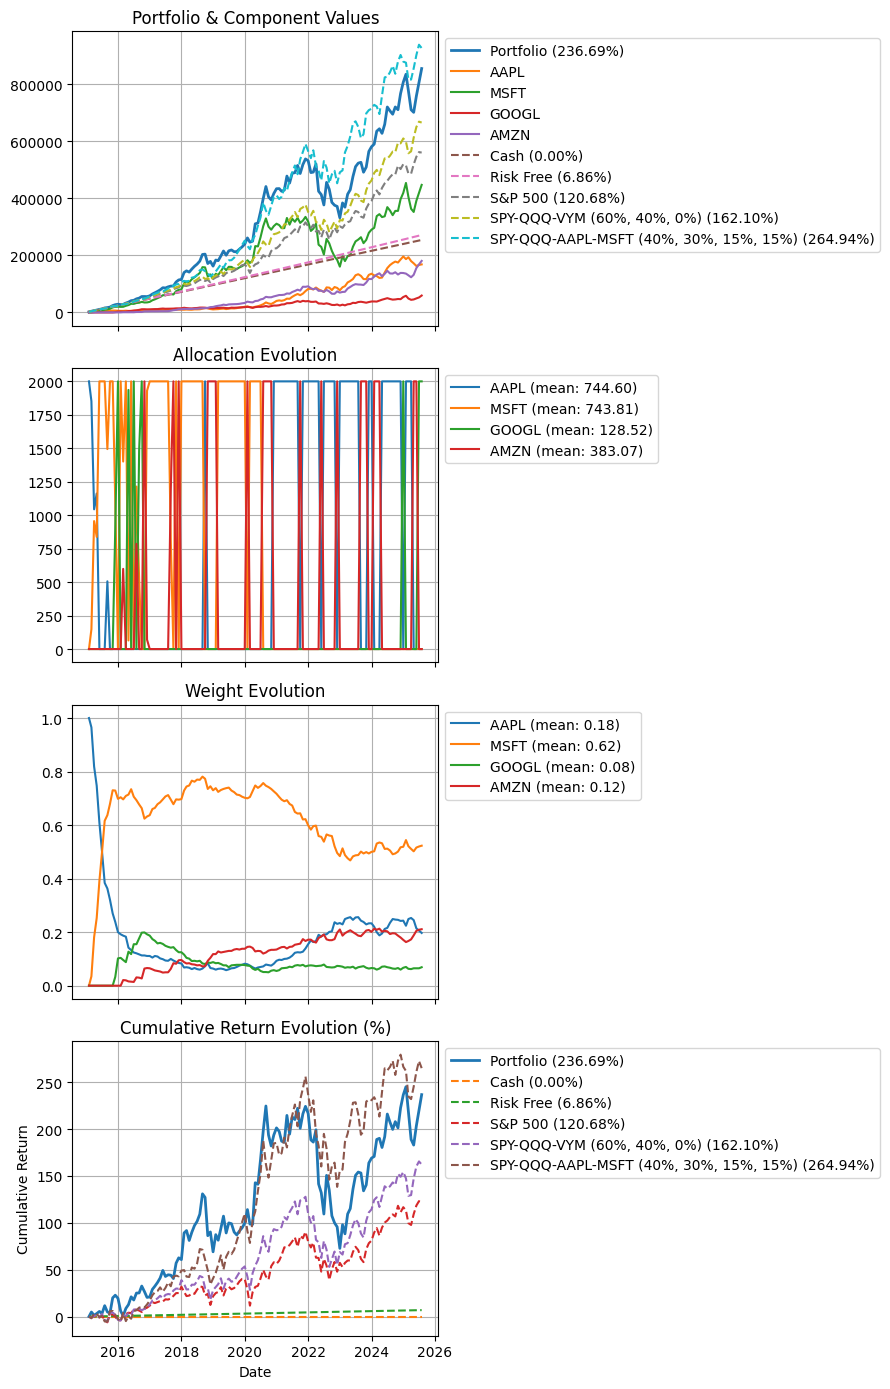

In [ ]:
plot_strategy(results['MVO'], initial_capital, monthly_cash, benchmarks)

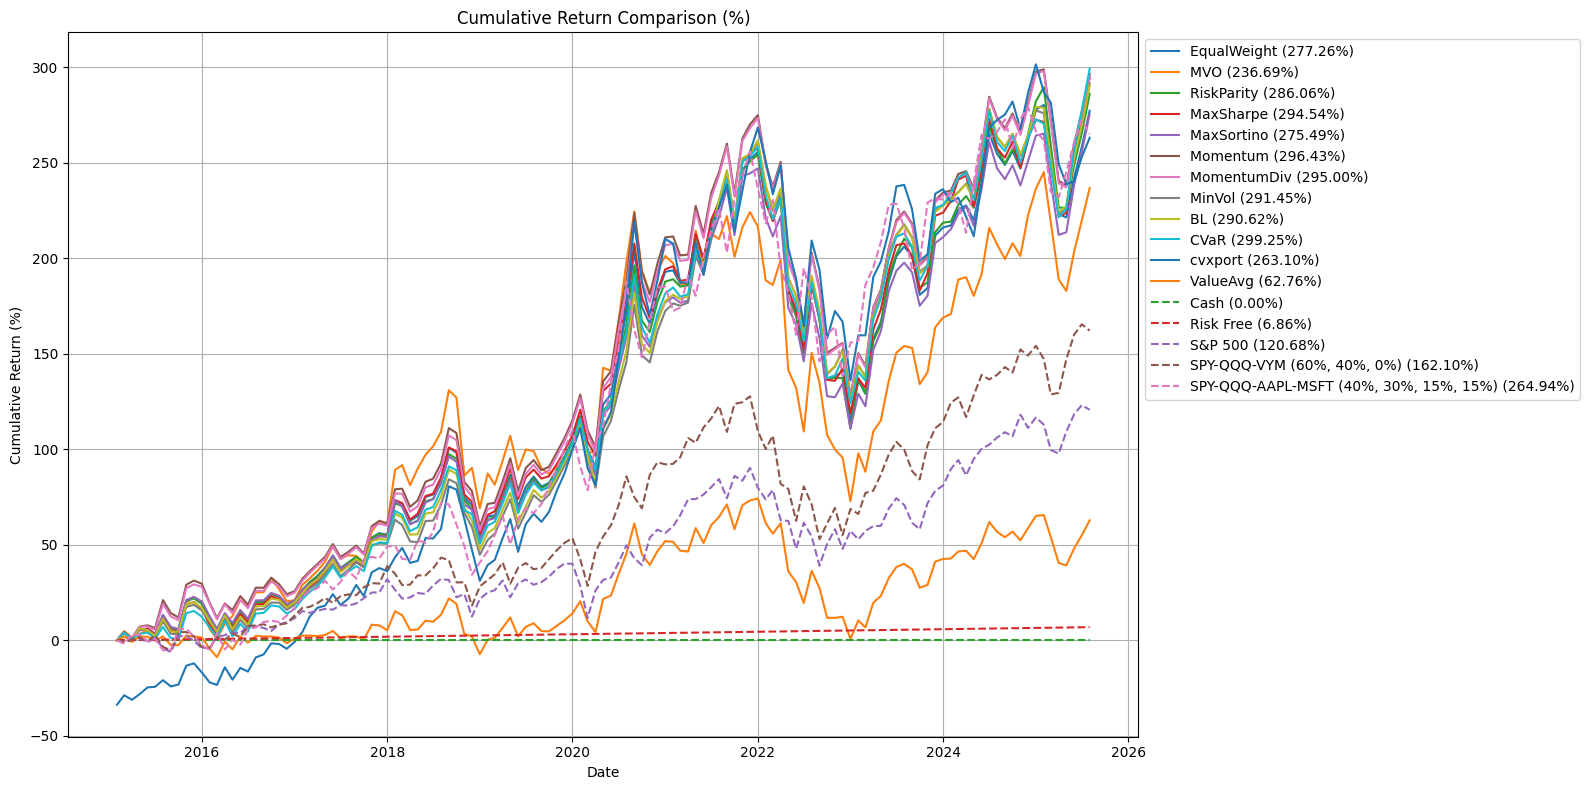

In [ ]:
plot_all_strategies_cumulative(results, initial_capital, monthly_cash, benchmarks)

In [ ]:
def calculate_time_weighted_return(total_values: pd.Series, monthly_cash: float) -> pd.Series:
    """
    Calculate the time-weighted return (TWR) series given a portfolio's total values and monthly contributions.

    Parameters:
    - total_values: Series of total portfolio values including monthly deposits
    - monthly_cash: Amount added at the start of each month

    Returns:
    - Series of cumulative time-weighted returns (in decimal, not percent)
    """

    # Compute net return each period, adjusting for the contribution at the start
    # Example
    # tv = [10 20 30] (assuming contribution: 5, net gain:5)
    # start_value = [NaN 10 30] (shift to the right)
    # net_gain for first elements = 20 - (10 + 5) = 5 which is the contribution
    tv = total_values.dropna()
    start_value = tv.shift(1) + monthly_cash
    net_gain = (tv - start_value)
    net_return = net_gain / start_value # belongs to [0, 1]
    net_return = net_return.dropna()

    # Chain-link returns
    twr = (1 + net_return).cumprod()

    # Manually inserting starting vlaue point 1.0  and reindex to original series
    twr = pd.concat([pd.Series([1.0], index=[tv.index[0]]), twr])
    twr = twr.sort_index()

    # twr is in growth terms (e.g. [1.00, 1.05, 1.1 , ... , 10.05, ...])
    # we subtract 1 to express it as return
    return twr - 1 # Return as growth from 0

In [ ]:
def plot_time_weighted_returns(strategy_data, monthly_cash, benchmarks=None):
    fig, ax = plt.subplots(figsize=(16, 6))
    for name, data in strategy_data.items():
        tv = data['total_values']
        twr = calculate_time_weighted_return(tv, monthly_cash)
        ax.plot(tv.index, twr * 100, label=f"{name} ({twr.iloc[-1]:.2%})")
    for bench in benchmarks.columns:
        bench_twr = calculate_time_weighted_return(tv, monthly_cash)
        ax.plot(benchmarks.index, bench_twr * 100, linestyle='--', label=f"Benchmark: {bench} ({bench_twr.iloc[-1]:.2%})")
    ax.set_title("Time-Weighted Returns (%) with Benchmarks")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return (%)")
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_drawdowns(strategy_data, monthly_cash, benchmarks=None):
    """
    Plot drawdowns of each strategy using time-weighted returns.
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    for name, data in strategy_data.items():
        twr = calculate_time_weighted_return(data['total_values'], monthly_cash)
        peak = twr.cummax()
        drawdown = (twr - peak) * 100
        ax.plot(twr.index, drawdown, label=f"{name} (Max DD: {drawdown.min():.2f}%)")
    if benchmarks is not None:
        for bench in benchmarks.columns:
            twr = calculate_time_weighted_return(benchmarks[bench], monthly_cash)
            peak = twr.cummax()
            drawdown = (twr - peak) * 100
            ax.plot(twr.index, drawdown, linestyle='--', label=f"Benchmark: {bench} (Max DD: {drawdown.min():.2f}%)")
    ax.set_title("Strategy Drawdowns (%)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Drawdown (%)")
    ax.legend(loc='lower left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_rolling_metrics(strategy_data, monthly_cash, benchmarks=None, rolling_window=6):
    """
    Plot rolling volatility and returns using time-weighted returns.
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    for name, data in strategy_data.items():
        twr = calculate_time_weighted_return(data['total_values'], monthly_cash)
        ret = twr.diff()
        rolling_vol = ret.rolling(rolling_window).std()
        rolling_ret = ret.rolling(rolling_window).mean()
        ax.plot(ret.index, rolling_ret * 100, label=f"{name} (Avg Ret: {rolling_ret.mean() * 100:.2f}%)")
    if benchmarks is not None:
        for bench in benchmarks.columns:
            twr = calculate_time_weighted_return(benchmarks[bench], monthly_cash)
            ret = twr.diff()
            rolling_ret = ret.rolling(rolling_window).mean()
            ax.plot(ret.index, rolling_ret * 100, linestyle='--', label=f"Benchmark: {bench} (Avg Ret: {rolling_ret.mean() * 100:.2f}%)")
    ax.set_title(f"Rolling {rolling_window}-Period Return (%)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Return (%)")
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_risk_return_scatter(strategy_data, monthly_cash, benchmarks=None):
    """
    Risk-return scatter plot using time-weighted returns.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for name, data in strategy_data.items():
        twr = calculate_time_weighted_return(data['total_values'], monthly_cash)
        returns = twr.diff().dropna()
        mean_return = returns.mean() * 12  # annualized
        volatility = returns.std() * (12 ** 0.5)
        ax.scatter(volatility, mean_return, label=f"{name}", s=100)
        ax.annotate(name, (volatility, mean_return), textcoords="offset points", xytext=(5,5), ha='left')
    if benchmarks is not None:
        for bench in benchmarks.columns:
            twr = calculate_time_weighted_return(benchmarks[bench], monthly_cash)
            returns = twr.diff().dropna()
            mean_return = returns.mean() * 12
            volatility = returns.std() * (12 ** 0.5)
            ax.scatter(volatility, mean_return, label=f"Benchmark: {bench}", marker='x', s=100)
            ax.annotate(bench, (volatility, mean_return), textcoords="offset points", xytext=(5,5), ha='left')
    ax.set_title("Risk vs. Return (Annualized TWR)")
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

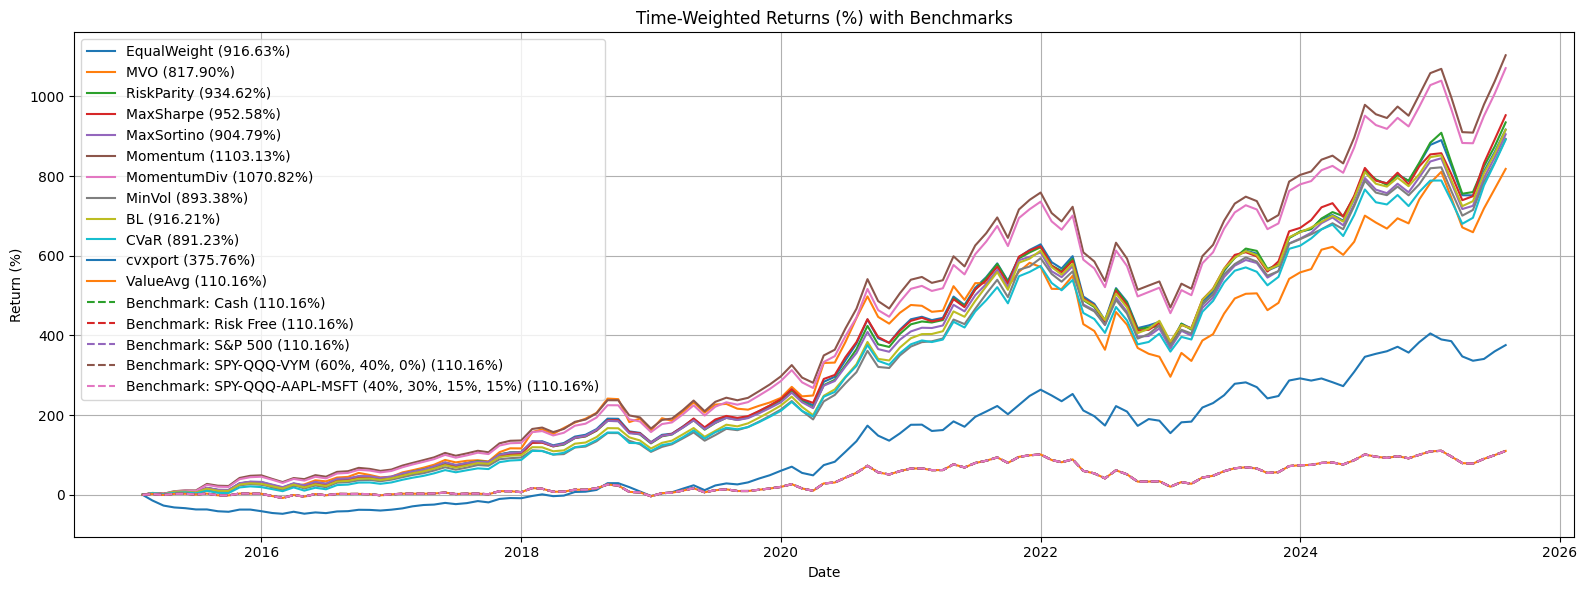

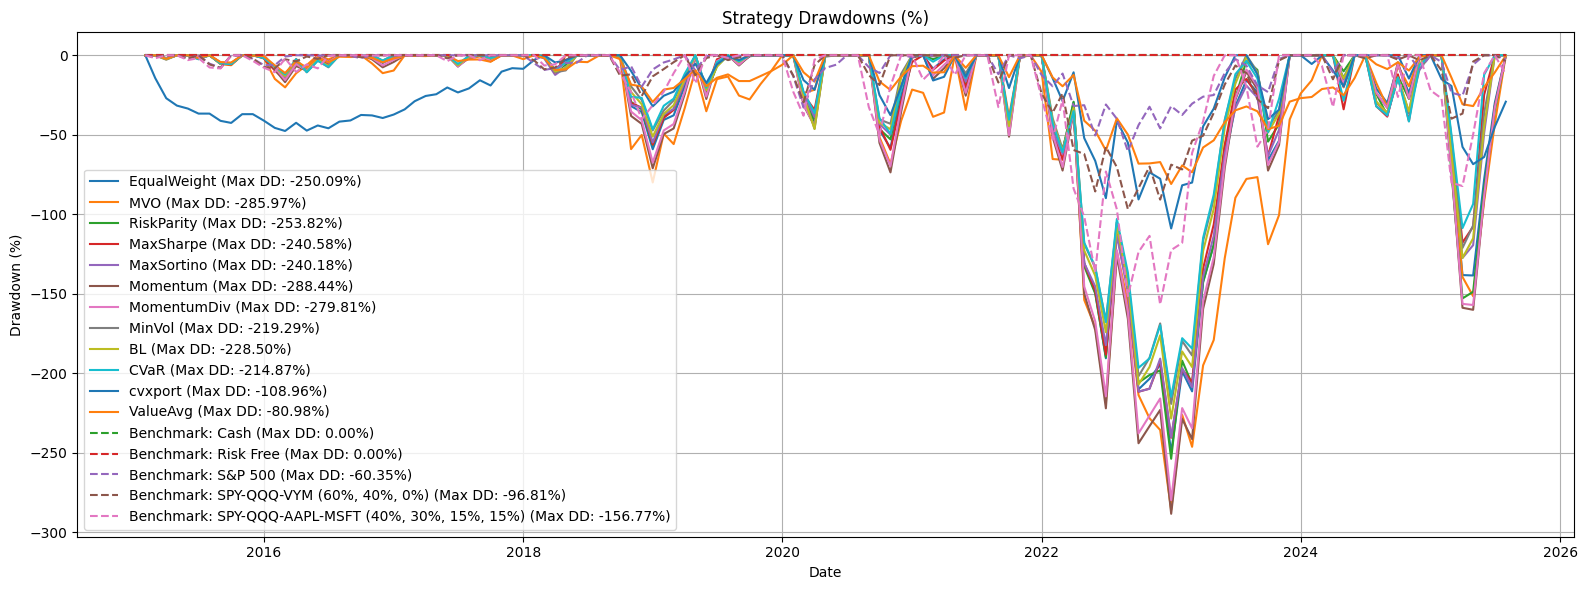

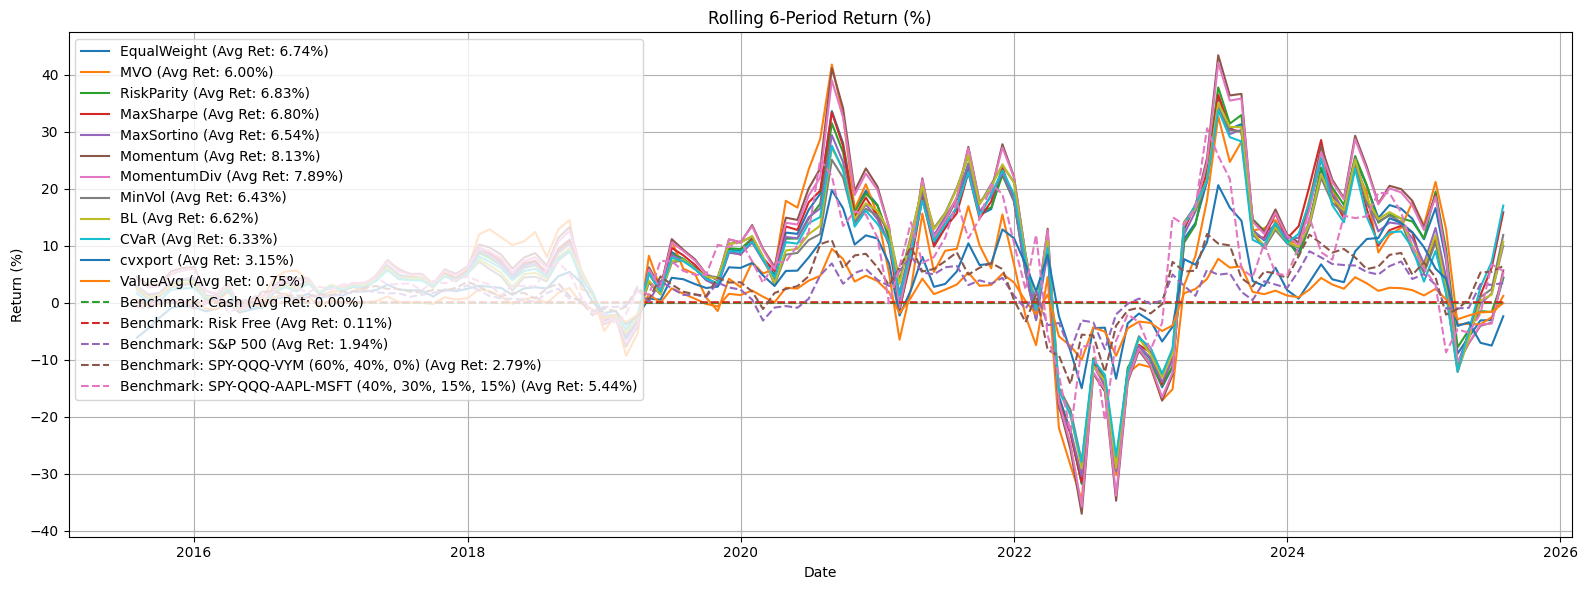

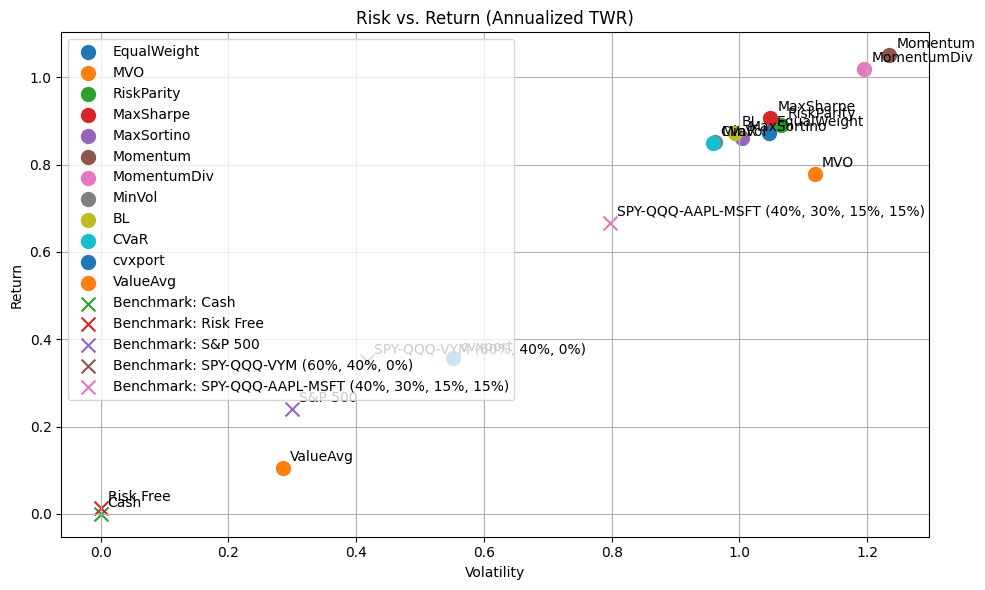

In [ ]:
plot_time_weighted_returns(results, monthly_cash, benchmarks)
plot_drawdowns(results, monthly_cash, benchmarks)
plot_rolling_metrics(results, monthly_cash, benchmarks)
plot_risk_return_scatter(results, monthly_cash, benchmarks)

In [ ]:
import pandas as pd
import numpy as np

def compute_strategy_metrics(strategy_data, monthly_cash, benchmarks=None, risk_free_rate=0.0125, key_benchmark=None):
    """
    Compute a table of key performance metrics for all strategies and benchmarks using time-weighted returns.

    Parameters:
    - strategy_data: dict of strategy results
    - monthly_cash: monthly capital added
    - benchmark_series: pd.DataFrame with benchmark series (e.g. 'SPY')
    - risk_free_rate: annual risk-free rate in decimal (e.g., 0.02)

    Returns:
    - pd.DataFrame with strategy/benchmark metrics
    """
    metrics = []

    def compute_indicators(twr_series, name, key_benchmark=None):
        returns = twr_series.diff().dropna()
        ann_return = returns.mean() * 12
        ann_vol = returns.std() * np.sqrt(12)
        sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol != 0 else np.nan

        downside = returns[returns < 0]
        sortino = (ann_return - risk_free_rate) / (downside.std() * np.sqrt(12)) if downside.std() > 0 else np.nan

        peak = twr_series.cummax()
        drawdown = (twr_series - peak)
        max_dd = drawdown.min()

        cagr = (1 + twr_series.iloc[-1])**(12 / len(twr_series)) - 1

        if key_benchmark is not None:
            key_bench_twr = calculate_time_weighted_return(key_benchmark, monthly_cash)
            key_bench_returns = key_bench_twr.diff().dropna()
            key_bench_returns.reindex(returns.index).dropna()
            excess_returns = returns - key_bench_returns
            info_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12) if excess_returns.std() > 0 else np.nan
        else:
            info_ratio = np.nan

        return {
            'Name': name,
            'CAGR': cagr,
            'Volatility': ann_vol,
            'Downside Volatility': downside.std(),
            'Sharpe': sharpe,
            'Sortino': sortino,
            'Max Drawdown': max_dd,
            'Information Ratio': info_ratio
        }

    # Strategy metrics
    for name, data in strategy_data.items():
        twr = calculate_time_weighted_return(data['total_values'], monthly_cash)
        #bench_twr = calculate_time_weighted_return(benchmarks.iloc[:, 0], monthly_cash) if benchmarks is not None else None
        metrics.append(compute_indicators(twr, name, key_benchmark))

    # Benchmark metrics
    if benchmarks is not None:
        for col in benchmarks.columns:
            twr = calculate_time_weighted_return(benchmarks[col], monthly_cash)
            metrics.append(compute_indicators(twr, f"Benchmark: {col}", key_benchmark))

    return pd.DataFrame(metrics).set_index("Name").round(4)


In [ ]:
metrics_table = compute_strategy_metrics(results, monthly_cash=2000, benchmarks=benchmarks, risk_free_rate=0.0125, key_benchmark=bm_spy)
display(metrics_table)

,CAGR,Volatility,Downside Volatility,Sharpe,Sortino,Max Drawdown,Information Ratio
Name,,,,,,,
EqualWeight,0.2450,1.0470,0.2316,0.8218,1.0725,-2.5009,0.5822
MVO,0.2330,1.1177,0.2464,0.6858,0.8980,-2.8597,0.4658
RiskParity,0.2471,1.0654,0.2432,0.8238,1.0417,-2.5382,0.5896
MaxSharpe,0.2491,1.0486,0.2167,0.8533,1.1917,-2.4058,0.6143
MaxSortino,0.2436,1.0036,0.2193,0.8462,1.1181,-2.4018,0.5959
Momentum,0.2650,1.2346,0.2678,0.8408,1.1189,-2.8844,0.6384
MomentumDiv,0.2617,1.1957,0.2606,0.8425,1.1157,-2.7981,0.6332
MinVol,0.2423,0.9615,0.2052,0.8719,1.1796,-2.1929,0.6100
BL,0.2449,0.9931,0.2143,0.8661,1.1584,-2.2850,0.6131


In [ ]:
# prompt: I think there is something wrong with how I calculate the time weighted returns for which the goal was to not inflate performance with the added monthly cash, Sharpe ratio of risk free strategy should be 0 but now it has a value

import pandas as pd
import numpy as np
def calculate_time_weighted_return(total_values: pd.Series, monthly_cash: float) -> pd.Series:
    """
    Calculate the time-weighted return (TWR) series given a portfolio's total values and monthly contributions.

    Parameters:
    - total_values: Series of total portfolio values including monthly deposits
    - monthly_cash: Amount added at the start of each month

    Returns:
    - Series of cumulative time-weighted returns (in decimal, not percent)
    """

    # Compute net return each period, adjusting for the contribution at the start
    # The cash is assumed to be added *before* the period's return is calculated.
    # So, the return for period 'i' is (Value_at_End_i - Value_at_Start_i) / Value_at_Start_i
    # Value_at_Start_i = Value_at_End_(i-1) + monthly_cash

    tv = total_values.dropna()

    # Calculate the value at the start of each period (after cash injection)
    start_value_of_period = tv.shift(1).fillna(initial_capital) + monthly_cash

    # Handle the very first period separately where there is no previous value to shift
    # The value at the start of the first period is the initial capital + first monthly cash injection
    start_value_of_period.iloc[0] = initial_capital + monthly_cash

    # Calculate the return for each period
    # Return_i = (Value_at_End_i - Value_at_Start_i) / Value_at_Start_i
    period_return = (tv - start_value_of_period) / start_value_of_period

    # Ensure no division by zero if start_value_of_period is 0
    period_return = period_return.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Chain-link returns to get the cumulative TWR index
    # Cumulative TWR_i = (1 + Return_1) * (1 + Return_2) * ... * (1 + Return_i)
    # The TWR index starts at 1.0
    twr_index = (1 + period_return).cumprod()

    # The TWR is the cumulative TWR index minus 1
    return twr_index - 1
